# Kmeans Clustering

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplitModel

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [2]:
# Change the number of cores in this code block
# by setting `spark.master` to `local[n]` where
# n is the number of cores

conf = pyspark.SparkConf().setAll([('spark.master', 'local[4]'),
                                   ('spark.app.name', 'Basic Setup')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-05-20 17:26:52,068 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.option("header",True).csv("file:///home/work/data/final_movies_df_10.csv", inferSchema=True)
df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- avg_rating: double (nullable = true)
 |-- movieYear: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- Crime: double (nullable = true)
 |-- Romance: double (nullable = true)
 |-- Thriller: double (nullable = true)
 |-- Adventure: double (nullable = true)
 |-- Drama: double (nullable = true)
 |-- War: double (nullable = true)
 |-- Documentary: double (nullable = true)
 |-- Fantasy: double (nullable = true)
 |-- Mystery: double (nullable = true)
 |-- Musical: double (nullable = true)
 |-- Animation: double (nullable = true)
 |-- Film-Noir: double (nullable = true)
 |-- Horror: double (nullable = true)
 |-- Western: double (nullable = true)
 |-- Comedy: double (nullable = true)
 |-- Children: double (nullable = true)
 |-- Action: double (nullable = true)
 |-- Sci-Fi: double (nullable = true)



In [4]:
df.show(5)

+-------+--------------------+------------------+---------+--------------------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+------+-------+------+--------+------+------+
|movieId|               title|        avg_rating|movieYear|              genres|Crime|Romance|Thriller|Adventure|Drama|War|Documentary|Fantasy|Mystery|Musical|Animation|Film-Noir|Horror|Western|Comedy|Children|Action|Sci-Fi|
+-------+--------------------+------------------+---------+--------------------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+------+-------+------+--------+------+------+
|   1088|Dirty Dancing (1987)|  3.25002094679514|     1987|Drama|Musical|Rom...|  0.0|    1.0|     0.0|      0.0|  1.0|0.0|        0.0|    0.0|    0.0|    1.0|      0.0|      0.0|   0.0|    0.0|   0.0|     0.0|   0.0|   0.0|
|   1580|Men in Black (a.k...|3.5817083457378187|     1997|Action|Comedy|Sci-Fi|  0.0|    0.0|     0

*Checking null values in each column*

In [5]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------+-----+----------+---------+------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+------+-------+------+--------+------+------+
|movieId|title|avg_rating|movieYear|genres|Crime|Romance|Thriller|Adventure|Drama|War|Documentary|Fantasy|Mystery|Musical|Animation|Film-Noir|Horror|Western|Comedy|Children|Action|Sci-Fi|
+-------+-----+----------+---------+------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+------+-------+------+--------+------+------+
|      0|    0|         0|       24|     0|    0|      0|       0|        0|    0|  0|          0|      0|      0|      0|        0|        0|     0|      0|     0|       0|     0|     0|
+-------+-----+----------+---------+------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+------+-------+------+--------+------+------+



*Printing movies without year in it*

In [6]:
#Doing toPandas() for pretty printing
df.filter(col('movieYear').isNull()).select('title').toPandas()

,title
0,The King
1,Science Fiction Volume One: The Osiris Child
2,Mara
3,Angel Has Fallen
4,Trophy Kids
5,Falling Inn Love
6,The Perfect Date
7,In the Tall Grass
8,Tau
9,Ready Player One


In [7]:
df.describe().toPandas()

,summary,movieId,title,avg_rating,movieYear,genres,Crime,Romance,Thriller,Adventure,...,Mystery,Musical,Animation,Film-Noir,Horror,Western,Comedy,Children,Action,Sci-Fi
0,count,24009,24009,24009,23985,24009,24009,24009,24009,24009,...,24009,24009,24009,24009,24009,24009,24009,24009,24009,24009
1,mean,70788.93344162605,None,3.2003455170428925,1994.7507608922242,None,0.10745970261152069,0.14815277604231747,0.17372651922195842,0.09159065350493564,...,0.05747844558290641,0.0301137073597401,0.057436794535382564,0.010745970261152068,0.11041692698571369,0.019159481860968802,0.3237119413553251,0.055895705777000294,0.14290474405431297,0.07580490649339831
2,stddev,62574.92667477875,None,0.4939954796797395,22.038548812964635,None,0.30970326109458013,0.35525876163929826,0.37888203284832367,0.28845323933383626,...,0.23275938305937793,0.1709037405567116,0.23268017569029853,0.10310643614230844,0.3134152526066884,0.13708821565464424,0.4679013134320066,0.22972499630498883,0.3499829709256203,0.2646912177941029
3,min,1,"""""""Great Performances"""" Cats (1998)""",0.6785714285714286,1874,Action,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,max,208737,貞子3D (2012),4.483096085409253,2019,Western,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [34]:
col_names = df.columns
exc_cols = ['movieId', 'title', 'genres', 'movieYear']
feat_cols = sorted(list(set(col_names).difference(set(exc_cols))))
feat_cols

['Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western',
 'avg_rating']

### Creating features

### Vector assembler to create feature vector column

In [9]:
assembler = VectorAssembler(inputCols=feat_cols, outputCol='features', handleInvalid='skip')
final_df = assembler.transform(df)

In [10]:
final_df.show(5)

2022-05-20 17:27:02,152 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+------------------+---------+--------------------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+------+-------+------+--------+------+------+--------------------+
|movieId|               title|        avg_rating|movieYear|              genres|Crime|Romance|Thriller|Adventure|Drama|War|Documentary|Fantasy|Mystery|Musical|Animation|Film-Noir|Horror|Western|Comedy|Children|Action|Sci-Fi|            features|
+-------+--------------------+------------------+---------+--------------------+-----+-------+--------+---------+-----+---+-----------+-------+-------+-------+---------+---------+------+-------+------+--------+------+------+--------------------+
|   1088|Dirty Dancing (1987)|  3.25002094679514|     1987|Drama|Musical|Rom...|  0.0|    1.0|     0.0|      0.0|  1.0|0.0|        0.0|    0.0|    0.0|    1.0|      0.0|      0.0|   0.0|    0.0|   0.0|     0.0|   0.0|   0.0|(19,[0,1,14,18],[...|
|   1580|Men in 

#### We might not need scaling, but did it anyway for learning purpose

In [11]:
# from pyspark.ml.feature import StandardScaler
# scaler = StandardScaler(inputCol='features',
#                        outputCol='scaled_feat',
#                        withStd=True,
#                        withMean=False
#                        )
# scaled_model = scaler.fit(final_df)
# cluster_df = scaled_model.transform(final_df)

#### Cluster Evaluator to check how close the points in individual clusters are ?

In [14]:
%%time
kmeans_algo = KMeans(featuresCol='features', seed=0, maxIter=1000, distanceMeasure="cosine")
evaluator = ClusteringEvaluator(predictionCol='prediction',
                          featuresCol='features',
                          metricName='silhouette',
                          distanceMeasure='cosine')


grid = ParamGridBuilder().addGrid(kmeans_algo.k, list(range(10,1001,10))).build()

tvs = TrainValidationSplit(estimator=kmeans_algo, estimatorParamMaps=grid, evaluator=evaluator, parallelism=1, seed=0)
tvsModel = tvs.fit(final_df)

2022-05-20 17:28:25,734 WARN execution.CacheManager: Asked to cache already cached data.
2022-05-20 17:28:25,738 WARN execution.CacheManager: Asked to cache already cached data.


CPU times: user 11.4 s, sys: 2.72 s, total: 14.1 s
Wall time: 1h 36min 43s


In [19]:
%%time
evaluator.evaluate(tvsModel.transform(final_df))

CPU times: user 65.8 ms, sys: 9.04 ms, total: 74.8 ms
Wall time: 34.4 s


0.522210564631767

In [23]:
tvsModel.bestModel

KMeansModel: uid=KMeans_70b0a0e61174, k=170, distanceMeasure=cosine, numFeatures=19

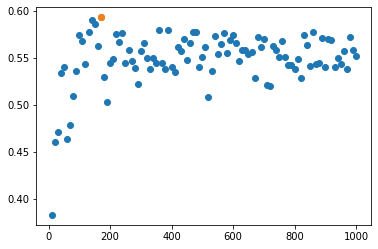

In [33]:
plt.scatter(list(range(10,1001,10)), tvsModel.validationMetrics)
plt.scatter(list(range(10,1001,10))[16], tvsModel.validationMetrics[16])

In [12]:
eval = ClusteringEvaluator(predictionCol='prediction',
                          featuresCol='features',
                          metricName='silhouette',
                          distanceMeasure='cosine')

In [13]:
### KMeans clustering 

In [14]:
silhouette_score = {}
print("""
Silhouette Scores for K Means Clustering
========================================
Model\tScore\t
=====\t=====\t
""")
start = time.time()
for k in range(10,1501,10):
    kmeans_algo = KMeans(featuresCol='features', k=k, seed=0, maxIter=1000, distanceMeasure="cosine")
    kmeans_fit = kmeans_algo.fit(final_df)
    output = kmeans_fit.transform(final_df)
    score = eval.evaluate(output)
    silhouette_score[k] = score
    if k % 100 == 0:
        # aaa = max(silhouette_score, key = silhouette_score.get) 
        # print(f"Max cluster: {aaa} Value: {silhouette_score[aaa]}")
        print(k)
        print(silhouette_score[k])
    # silhouette_score.append(score)
    # print(f"K{k}\t{np.round(score,3)}\t")
end = time.time()
print(f"Runtime: {end - start}")


Silhouette Scores for K Means Clustering
Model	Score	
=====	=====	



100
0.4911384049346459


200
0.6011487277159002


300
0.6037404968788648


400
0.57048802247429


500
0.5610350492519948


600
0.5864398393095508


700
0.5973663145855808


800
0.6086745281340338


900
0.5901716824791318


1000
0.61039176154859


1100
0.6198625095479733


1200
0.6231700509471332


1300
0.6225412733574709


1400
0.6323966128250387


1500
0.634802272921113
Runtime: 11041.68783903122


In [15]:
# silhouette_score
score_df = pd.DataFrame(silhouette_score.items(), columns=['clusters', 'score'])
score_df

,clusters,score
0,10,0.330907
1,20,0.442582
2,30,0.494541
3,40,0.485320
4,50,0.471295
...,...,...
145,1460,0.636298
146,1470,0.640617
147,1480,0.634447
148,1490,0.635793


In [16]:
score_df.loc[score_df.score.argmax(), :]

clusters    1370.00000
score          0.64189
Name: 136, dtype: float64

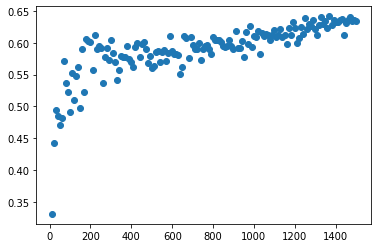

In [18]:
plt.scatter(score_df.clusters, score_df.score)

In [34]:
write_files = False
if write_files:
    score_df.to_csv('../../data/res_cosine_all.csv', index=False, header=True)

#### The above score should give us idea if points inside clusters are close to each other.

In [36]:
spark.stop()